<a href="https://colab.research.google.com/github/RMichae1/PyroStudies/blob/master/Bayesian_Imputation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from numpy.random import random as np_random
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import datasets

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

from jax import ops, random
from jax.scipy.special import expit
import jax.numpy as jnp
from numpyro.diagnostics import hpdi

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
iris_data = datasets.load_iris() 

In [3]:
iris_df = pd.DataFrame(data=np.c_[iris_data['data'], iris_data['target']],
                      columns=iris_data['feature_names'] + ['target'])
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0


In [4]:
iris_df["target"] = iris_df.target.astype("int")
# select 2 species for ease of use
iris_df = iris_df[iris_df.target.isin([0, 1])]
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
95,5.7,3.0,4.2,1.2,1
96,5.7,2.9,4.2,1.3,1
97,6.2,2.9,4.3,1.3,1
98,5.1,2.5,3.0,1.1,1


In [5]:
random_vec = np_random(iris_df["petal length (cm)"].shape)<0.5
iris_df["petal length (cm)"] = iris_df["petal length (cm)"].where(random_vec, 
                                                                  other=np.nan)
iris_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,NaN,0.2,0
1,4.9,3.0,NaN,0.2,0
2,4.7,3.2,NaN,0.2,0
3,4.6,3.1,NaN,0.2,0
4,5.0,3.6,NaN,0.2,0
...,...,...,...,...,...
95,5.7,3.0,NaN,1.2,1
96,5.7,2.9,NaN,1.3,1
97,6.2,2.9,NaN,1.3,1
98,5.1,2.5,3.0,1.1,1


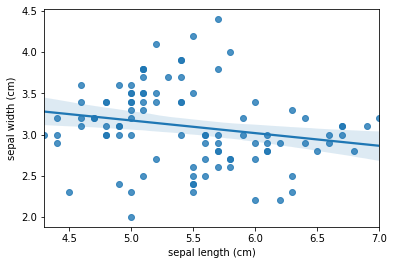

In [6]:
sns.regplot("sepal length (cm)", "sepal width (cm)", iris_df)

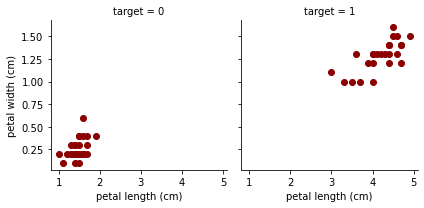

In [7]:
t = sns.FacetGrid(iris_df, col="target")
t.map(plt.scatter, "petal length (cm)", "petal width (cm)", color="darkred")
plt.savefig("./lr_lw.png")

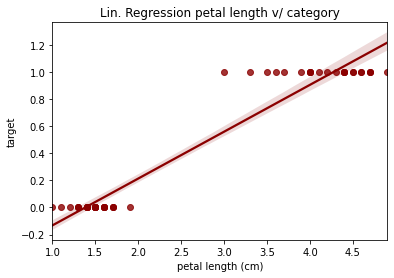

In [8]:
sns.regplot("petal length (cm)", "target", color="darkred", data=iris_df)
plt.title("Lin. Regression petal length v/ category")
plt.savefig("./lr_target_p_len.png")

In [9]:
iris_data=dict(s_len=iris_df["sepal length (cm)"].values,
              s_width=iris_df["sepal width (cm)"].values,
              p_len=iris_df["petal length (cm)"].values,
              p_width=iris_df["petal width (cm)"].values,
              target=iris_df.target.values)
iris_data

{'p_len': array([nan, nan, nan, nan, nan, 1.7, 1.4, nan, nan, nan, 1.5, 1.6, nan,
        1.1, nan, nan, nan, 1.4, 1.7, 1.5, 1.7, 1.5, 1. , nan, nan, 1.6,
        1.6, nan, nan, 1.6, nan, 1.5, 1.5, 1.4, 1.5, 1.2, 1.3, 1.4, 1.3,
        1.5, nan, 1.3, nan, 1.6, 1.9, nan, nan, 1.4, nan, 1.4, 4.7, nan,
        4.9, nan, 4.6, nan, nan, 3.3, 4.6, nan, nan, nan, 4. , 4.7, 3.6,
        4.4, nan, nan, 4.5, nan, nan, 4. , nan, 4.7, 4.3, 4.4, nan, nan,
        nan, 3.5, nan, 3.7, 3.9, nan, nan, 4.5, nan, 4.4, nan, 4. , 4.4,
        nan, 4. , nan, 4.2, nan, nan, nan, 3. , 4.1]),
 'p_width': array([0.2, 0.2, 0.2, 0.2, 0.2, 0.4, 0.3, 0.2, 0.2, 0.1, 0.2, 0.2, 0.1,
        0.1, 0.2, 0.4, 0.4, 0.3, 0.3, 0.3, 0.2, 0.4, 0.2, 0.5, 0.2, 0.2,
        0.4, 0.2, 0.2, 0.2, 0.2, 0.4, 0.1, 0.2, 0.2, 0.2, 0.2, 0.1, 0.2,
        0.2, 0.3, 0.3, 0.2, 0.6, 0.4, 0.3, 0.2, 0.2, 0.2, 0.2, 1.4, 1.5,
        1.5, 1.3, 1.5, 1.3, 1.6, 1. , 1.3, 1.4, 1. , 1.5, 1. , 1.4, 1.3,
        1.4, 1.5, 1. , 1.5, 1.1, 1.8, 1.3, 1.5, 1

In [10]:
print("Petal Length μ = {}".format(iris_df["petal length (cm)"].mean()))
print("Petal Length σ^2 = {}".format(iris_df["petal length (cm)"].std()))

Petal Length μ = 2.7452830188679247
Petal Length σ^2 = 1.4097962261011956


In [11]:
p_len = iris_df["petal length (cm)"]
print("Amount missing: {}".format(len(np.array(np.isnan(p_len).astype(int)).nonzero()[0])))
np.array(np.isnan(p_len).astype(int)).nonzero()[0]

Amount missing: 47


array([ 0,  1,  2,  3,  4,  7,  8,  9, 12, 14, 15, 16, 23, 24, 27, 28, 30,
       40, 42, 45, 46, 48, 51, 53, 55, 56, 59, 60, 61, 66, 67, 69, 70, 72,
       76, 77, 78, 80, 83, 84, 86, 88, 91, 93, 95, 96, 97])

In [12]:
def model(s_len, s_width, p_len, p_width, target=None):
    b_s_len = numpyro.sample("b_s_len", dist.Normal(0,1))
    b_s_width = numpyro.sample("b_s_width", dist.Normal(0,1))
    b_p_width = numpyro.sample("b_p_width", dist.Normal(0,1))
    
    # impute length
    len_mu = numpyro.sample("p_length_mu", dist.Normal(jnp.ones(len(p_len))*3, 0.01))
    len_sigma = abs(numpyro.sample("p_length_sigma", dist.Normal(jnp.ones(len(p_len)), 0.01)))
    len_is_nan = np.isnan(p_len)
    len_nan_idx = np.array(np.isnan(p_len).astype(int)).nonzero()[0]

    len_impute = numpyro.sample("len_impute", dist.Normal(len_mu[len_nan_idx], 
                                                          len_sigma[len_nan_idx]).mask(False))

    p_len = ops.index_update(p_len, len_nan_idx, len_impute)
    
    numpyro.sample("p_length", dist.Normal(len_mu, len_sigma), obs=p_len)
    
    l = numpyro.sample("l", dist.Normal(0, 1))
    b_len = numpyro.sample("b_length", dist.Normal(0, 1))
    logits = l + b_len * p_len
    
    logits = logits + b_s_len*s_len + b_s_width*s_width + b_p_width*p_width
    
    if target is None:
        # prediction case
        probs = expit(logits)
        numpyro.sample("probs", dist.Delta(probs))

    numpyro.sample("target", dist.Bernoulli(logits=logits), obs=target)

In [13]:
mcmc = MCMC(NUTS(model=model), 5000, 10000, num_chains=1)
mcmc.run(random.PRNGKey(42), **iris_data)

mcmc.print_summary()

sample: 100%|██████████| 15000/15000 [01:24<00:00, 177.33it/s, 31 steps of size 1.42e-01. acc. prob=0.89]



                        mean       std    median      5.0%     95.0%     n_eff     r_hat
          b_length      0.55      0.39      0.54     -0.11      1.18  13671.91      1.00
         b_p_width      3.00      0.74      2.99      1.83      4.24  13212.42      1.00
           b_s_len      0.76      0.48      0.76     -0.01      1.56   8765.74      1.00
         b_s_width     -2.49      0.66     -2.48     -3.56     -1.41   9752.81      1.00
                 l     -0.37      0.99     -0.37     -1.93      1.33  17234.02      1.00
     len_impute[0]      2.96      0.99      2.95      1.36      4.63  22473.80      1.00
     len_impute[1]      2.89      0.99      2.89      1.25      4.51  21203.46      1.00
     len_impute[2]      2.94      0.98      2.95      1.35      4.54  23961.96      1.00
     len_impute[3]      2.93      0.99      2.94      1.30      4.55  22692.01      1.00
     len_impute[4]      2.97      1.01      2.96      1.26      4.59  22880.42      1.00
     len_impute[5]  

In [17]:
samples = mcmc.get_samples()

In [18]:
samples

{'b_length': DeviceArray([ 0.26473236,  0.90422314,  0.13349578, ..., -0.23111868,
               1.5031857 ,  0.6906538 ], dtype=float32),
 'b_p_width': DeviceArray([3.7696998, 1.7589914, 3.7733822, ..., 3.2661796, 2.3625705,
              3.5928218], dtype=float32),
 'b_s_len': DeviceArray([0.287731  , 1.1125053 , 0.6053869 , ..., 0.7022839 ,
              0.31945235, 0.34511983], dtype=float32),
 'b_s_width': DeviceArray([-1.8332169, -3.1975117, -2.005806 , ..., -2.3892868,
              -1.9523339, -1.9537458], dtype=float32),
 'l': DeviceArray([-0.1377089 , -0.6204354 ,  0.14292194, ...,  1.3937875 ,
              -2.4155486 , -1.1820538 ], dtype=float32),
 'len_impute': DeviceArray([[2.9191716, 3.747481 , 3.4118106, ..., 2.6481175, 3.5958624,
               3.9259028],
              [3.2438385, 2.1648953, 2.130211 , ..., 3.7324245, 3.3277156,
               2.2019832],
              [2.2448006, 3.2414007, 3.1760828, ..., 2.125116 , 2.8887365,
               4.226811 ],
          

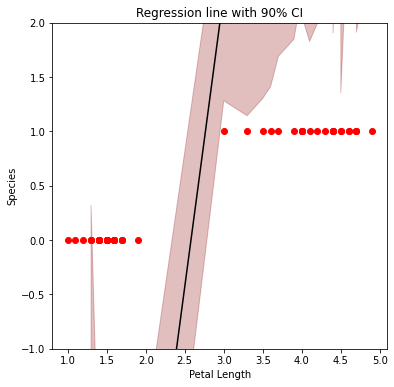

In [19]:
def plot_regression(x, y_mean, y_hpdi):
    # Sort values for plotting by x axis
    idx = jnp.argsort(x)
    petal_length = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]
    species = iris_df.target.values[idx]

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.plot(petal_length, mean, 'k')
    ax.plot(petal_length, species, 'ro')
    ax.fill_between(petal_length, hpdi[0], hpdi[1], alpha=0.25, color="darkred", interpolate=False)
    return ax

# Compute empirical posterior distribution over mu
posterior_mu = jnp.expand_dims(samples['l'], -1) + \
               jnp.expand_dims(samples['b_length'], -1) * iris_df["petal length (cm)"].values + \
               jnp.expand_dims(samples['b_s_len'], -1)*iris_df["sepal length (cm)"].values + \
               jnp.expand_dims(samples['b_s_width'], -1)*iris_df["sepal width (cm)"].values + \
               jnp.expand_dims(samples['b_p_width'], -1)*iris_df["petal width (cm)"].values

mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.95)
ax = plot_regression(iris_df["petal length (cm)"].values, mean_mu, hpdi_mu)
ax.set(xlabel='Petal Length', ylabel='Species', title='Regression line with 90% CI')
ax.set_ylim([-1, 2]);
plt.savefig("rp_sampled_90CI.png")